In [247]:
import numpy as np
import matplotlib.pyplot as plt
import corner

np.random.seed(1)

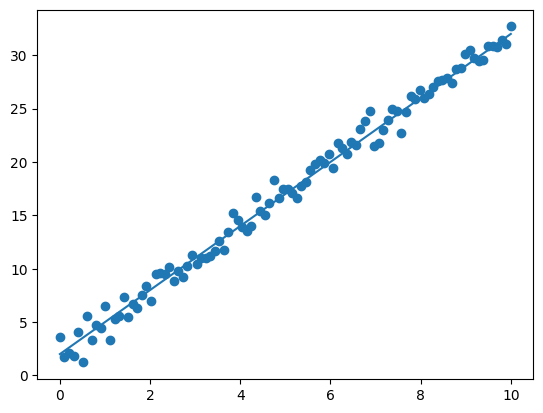

In [248]:
x = np.linspace(0,10, 100)
t0, t1 = 2,3
y = t0 + t1*x
data = y + np.random.normal(0, 1, size=len(y))

plt.plot(x,y)
plt.scatter(x,data)



In [ ]:
def likelihood(beta0, beta1, x, y, sigma=1):
    """Gaussian likelihood for linear model."""
    y_pred = beta0 + beta1 * x
    residuals = y - y_pred
    return np.exp(-0.5 * np.sum((residuals / sigma)**2))

def prior(beta0, beta1):
    """Flat prior (constant for all beta)."""
    sigma0 = 0.5
    p0 = np.exp(-0.5 * ((beta0-t0)/sigma0)**2)
    p1 = 1 if 2.5 <= beta1 <= 3.5 else 0
    return p0*p1

# Posterior density
def posterior(beta0, beta1, x, y):
    """Posterior density proportional to likelihood * prior."""
    return likelihood(beta0, beta1, x, y) * prior(beta0, beta1)

# Metropolis-Hastings Algorithm
def metropolis_hastings(iterations, initial, proposal_std, x, y):
    samples = [initial]
    current = initial
    
    for _ in range(iterations):
        # Propose new candidate
        proposal = np.random.normal(loc=current, scale=proposal_std, size=2)
        
        # Compute acceptance ratio
        p_current = posterior(current[0], current[1], x, y)
        p_proposal = posterior(proposal[0], proposal[1], x, y)
        alpha = min(1, p_proposal / p_current)
        
        # Accept/reject step
        if np.random.rand() < alpha:
            current = proposal  # Accept proposal
        
        samples.append(current)
    
    return np.array(samples)

# Parameters for MCMC
iterations = 100000
initial = [1, 1]  # Starting values for [beta0, beta1]
proposal_std = [0.5, 0.5]  # Standard deviation of proposal distribution

# Run Metropolis-Hastings
samples = metropolis_hastings(iterations, initial, proposal_std, x, y)

/tmp/ipykernel_23004/3815001931.py:32: RuntimeWarning: invalid value encountered in scalar divide
  alpha = min(1, p_proposal / p_current)
/tmp/ipykernel_23004/3815001931.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = min(1, p_proposal / p_current)


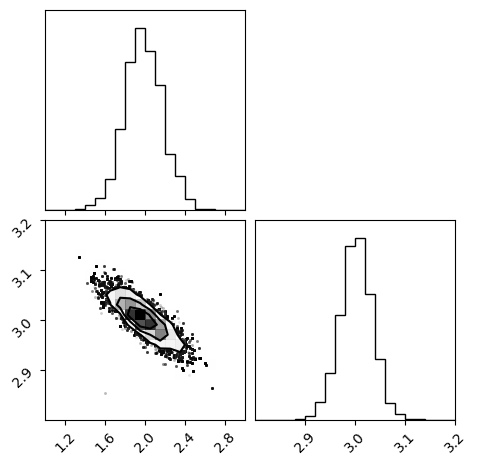

In [257]:
corner.corner(samples, range=[(1,3), (2.8,3.2)]);

In [258]:
# Random initial values for each chain
initial_points = [
    [np.random.uniform(-5, 5), np.random.uniform(-5, 5)] for _ in range(4)
]

# Run Metropolis-Hastings for each chain
chains = []
for i, initial in enumerate(initial_points):
    print(f"Running chain {i+1} with initial point {initial}")
    chain = metropolis_hastings(iterations, initial, proposal_std, x, y)
    chains.append(chain)

# Combine all chains
all_samples = np.vstack(chains)

Running chain 1 with initial point [1.0585346844137806, -4.875302774785039]


/tmp/ipykernel_23004/3815001931.py:32: RuntimeWarning: invalid value encountered in scalar divide
  alpha = min(1, p_proposal / p_current)
/tmp/ipykernel_23004/3815001931.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  alpha = min(1, p_proposal / p_current)


Running chain 2 with initial point [-0.9060874269200845, -2.8497911232912134]
Running chain 3 with initial point [-3.33171352248981, 2.800269131384513]
Running chain 4 with initial point [2.3221926356223985, -0.055442712387119286]


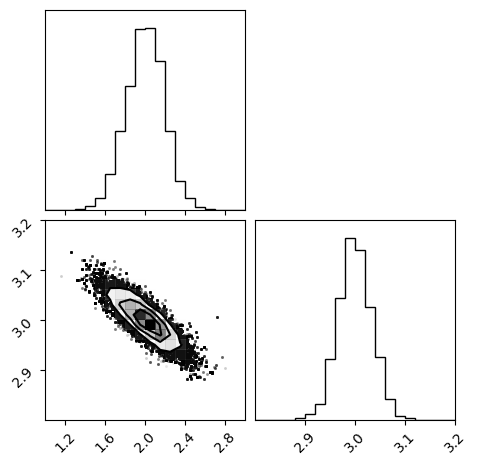

In [259]:
corner.corner(all_samples, range=[(1,3), (2.8,3.2)]);